# Obligatorio MLSI - Predicción de Precios de Airbnb en Buenos Aires

## Índice
1. [Carga de Datos](#1.-Carga-de-Datos)
2. [Análisis Exploratorio y Outliers](#2.-Análisis-Exploratorio-y-Outliers)
3. [Preprocesamiento de Datos](#3.-Preprocesamiento-de-Datos)
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Entrenamiento de Modelos](#5.-Entrenamiento-de-Modelos)
6. [Evaluación y Comparación](#6.-Evaluación-y-Comparación)
7. [Predicciones para Kaggle](#7.-Predicciones-para-Kaggle)

## 1. Carga de Datos

Importamos las librerías necesarias y cargamos el dataset de entrenamiento.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración de visualización
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

In [2]:
# Cargar datos
df = pd.read_csv('../sample_data/train.csv')
df_test = pd.read_csv('../sample_data/test.csv')

print(f"Dataset de entrenamiento: {df.shape}")
print(f"Dataset de test: {df_test.shape}")
print(f"\nPrimeras filas:")
df.head()

Dataset de entrenamiento: (16013, 15)
Dataset de test: (6864, 14)

Primeras filas:


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,30814163,"3 bedrooms, 2 bathrooms. Patio, terrace and BBQ!",157770305,Sara,Constitucion,-34.62142,-58.37754,Entire home/apt,2212,1,24,10-11-2019,2.19,4,337
1,32539509,Studio with balcony and gim @Palermo Hollywood,16133446,Luis & Florencia,Palermo,-34.57949,-58.43199,Entire home/apt,2691,2,0,NaN,NaN,52,179
2,36262352,Nice Niceto. Der Wohnung in Buenos aires,257784804,Diego,Palermo,-34.58298,-58.44265,Entire home/apt,1315,2,8,06-10-2019,1.64,1,22
3,1147359,"Soho Artist Studio, breakfast",4215940,Lilian,Palermo,-34.58937,-58.43274,Entire home/apt,2750,1,9,29-01-2019,0.12,6,343
4,26470465,Perfect get-away in Buenos Aires,166597104,Mariangeles,Retiro,-34.59448,-58.37936,Entire home/apt,1076,1,6,10-05-2019,0.42,2,339


In [3]:
# Información del dataset
print("Información del dataset:")
df.info()
print(f"\nValores nulos por columna:")
df.isnull().sum()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16013 non-null  int64  
 1   name                            16005 non-null  object 
 2   host_id                         16013 non-null  int64  
 3   host_name                       16000 non-null  object 
 4   neighbourhood                   16013 non-null  object 
 5   latitude                        16013 non-null  float64
 6   longitude                       16013 non-null  float64
 7   room_type                       16013 non-null  object 
 8   price                           16013 non-null  int64  
 9   minimum_nights                  16013 non-null  int64  
 10  number_of_reviews               16013 non-null  int64  
 11  last_review                     11463 non-null  object 
 12  reviews

id                                   0
name                                 8
host_id                              0
host_name                           13
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       4550
reviews_per_month                 4550
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [4]:
# Estadísticas descriptivas de la variable objetivo
print("="*60)
print("ESTADÍSTICAS DE PRECIO (Variable Objetivo)")
print("="*60)
print(df['price'].describe())
print(f"\nMedia:    ${df['price'].mean():,.2f}")
print(f"Mediana:  ${df['price'].median():,.2f}")
print(f"Desv. Std: ${df['price'].std():,.2f}")

ESTADÍSTICAS DE PRECIO (Variable Objetivo)
count     16013.000000
mean       3286.097046
std       13182.202856
min         120.000000
25%        1256.000000
50%        2033.000000
75%        2990.000000
max      597865.000000
Name: price, dtype: float64

Media:    $3,286.10
Mediana:  $2,033.00
Desv. Std: $13,182.20


## 2. Análisis Exploratorio y Outliers

### 2.1 Detección de Outliers en Price

In [5]:
# Análisis de outliers con IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_inf = df[df['price'] < limite_inferior]
outliers_sup = df[df['price'] > limite_superior]

print("="*60)
print("ANÁLISIS DE OUTLIERS CON MÉTODO IQR")
print("="*60)
print(f"Q1 (25%):              ${Q1:,.2f}")
print(f"Q3 (75%):              ${Q3:,.2f}")
print(f"IQR:                   ${IQR:,.2f}")
print(f"\nLímite inferior:       ${limite_inferior:,.2f}")
print(f"Límite superior:       ${limite_superior:,.2f}")
print(f"\nOutliers inferiores:   {len(outliers_inf)} ({len(outliers_inf)/len(df)*100:.2f}%)")
print(f"Outliers superiores:   {len(outliers_sup)} ({len(outliers_sup)/len(df)*100:.2f}%)")
print(f"\nPrecio mínimo:         ${df['price'].min():,.2f}")
print(f"Precio máximo:         ${df['price'].max():,.2f}")

ANÁLISIS DE OUTLIERS CON MÉTODO IQR
Q1 (25%):              $1,256.00
Q3 (75%):              $2,990.00
IQR:                   $1,734.00

Límite inferior:       $-1,345.00
Límite superior:       $5,591.00

Outliers inferiores:   0 (0.00%)
Outliers superiores:   1397 (8.72%)

Precio mínimo:         $120.00
Precio máximo:         $597,865.00


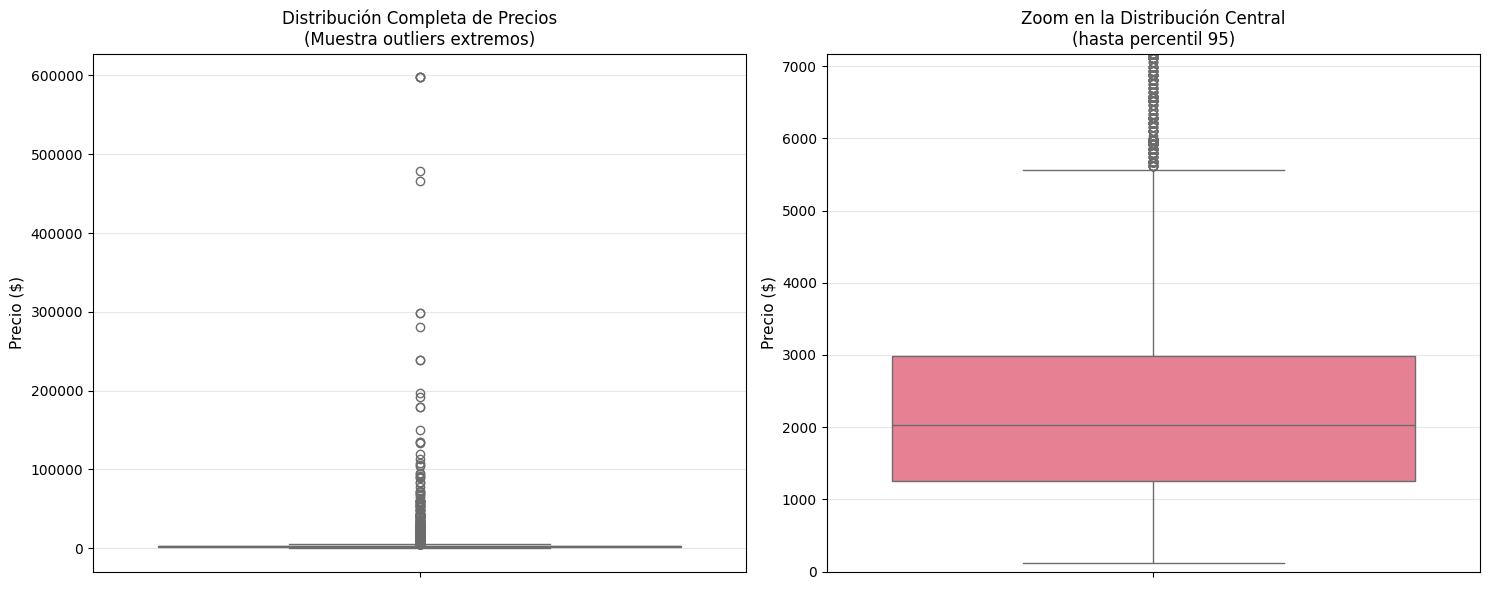

In [6]:
# Visualización de outliers - Boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Escala completa
sns.boxplot(y=df['price'], ax=axes[0])
axes[0].set_title('Distribución Completa de Precios\n(Muestra outliers extremos)', fontsize=12)
axes[0].set_ylabel('Precio ($)', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Zoom en percentil 95
sns.boxplot(y=df['price'], ax=axes[1])
axes[1].set_title('Zoom en la Distribución Central\n(hasta percentil 95)', fontsize=12)
axes[1].set_ylabel('Precio ($)', fontsize=11)
axes[1].set_ylim(0, df['price'].quantile(0.95))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('boxplot_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

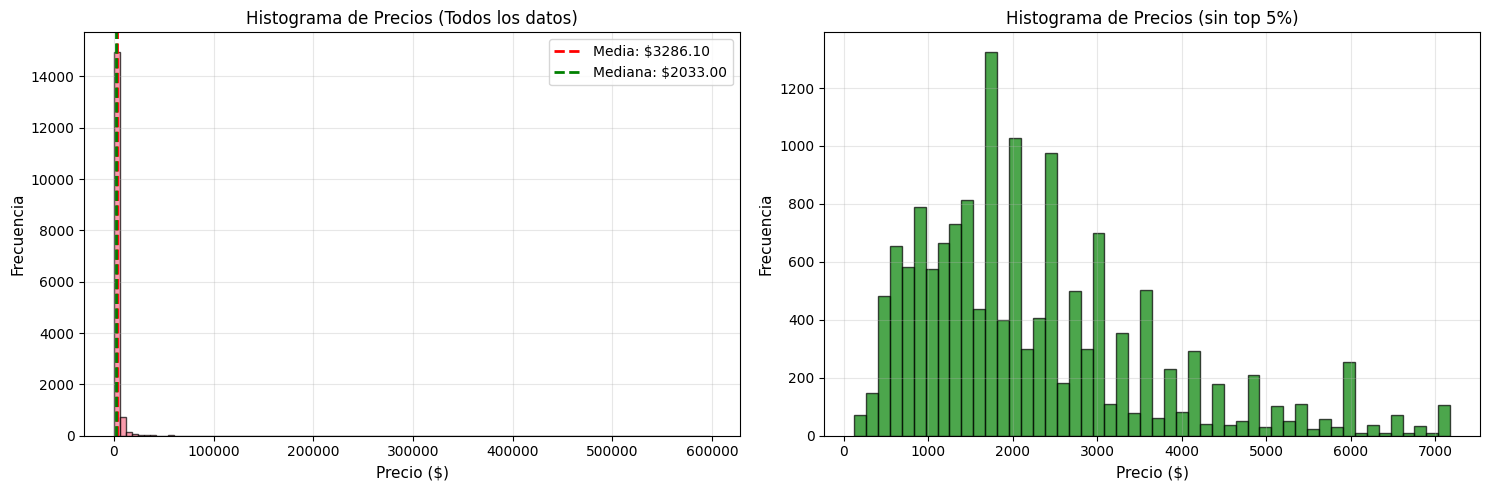

In [7]:
# Histograma de distribución de precios
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma completo
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(df['price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${df["price"].mean():.2f}')
axes[0].axvline(df['price'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: ${df["price"].median():.2f}')
axes[0].set_title('Histograma de Precios (Todos los datos)', fontsize=12)
axes[0].set_xlabel('Precio ($)', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histograma sin outliers extremos
df_no_outliers = df[df['price'] <= df['price'].quantile(0.95)]
axes[1].hist(df_no_outliers['price'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Histograma de Precios (sin top 5%)', fontsize=12)
axes[1].set_xlabel('Precio ($)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('histograma_precios.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Decisión sobre Outliers

Observamos que existen outliers en el extremo superior de la distribución. Procedemos a eliminar el top 5% de precios más altos para mejorar el rendimiento del modelo.

In [8]:
# Eliminación de outliers: top 5%
print("="*60)
print("ELIMINACIÓN DE OUTLIERS")
print("="*60)
print(f"Shape antes:  {df.shape}")

percentil_95 = df['price'].quantile(0.95)
print(f"Percentil 95: ${percentil_95:,.2f}")

df_clean = df[df['price'] <= percentil_95].copy()

print(f"Shape después: {df_clean.shape}")
print(f"Registros eliminados: {len(df) - len(df_clean)} ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")
print(f"\nNuevas estadísticas:")
print(f"Media:    ${df_clean['price'].mean():,.2f}")
print(f"Mediana:  ${df_clean['price'].median():,.2f}")
print(f"Máximo:   ${df_clean['price'].max():,.2f}")

ELIMINACIÓN DE OUTLIERS
Shape antes:  (16013, 15)
Percentil 95: $7,175.00
Shape después: (15252, 15)
Registros eliminados: 761 (4.75%)

Nuevas estadísticas:
Media:    $2,250.30
Mediana:  $1,913.00
Máximo:   $7,175.00


## 3. Preprocesamiento de Datos

### 3.1 Gestión de Valores Faltantes

In [9]:
# Imputación de valores nulos
print("Valores nulos antes de imputación:")
print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

# reviews_per_month: llenar con 0 (sin reseñas)
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)
df_test['reviews_per_month'] = df_test['reviews_per_month'].fillna(0)

print(f"\nValores nulos después de imputación:")
print(df_clean.isnull().sum().sum())

Valores nulos antes de imputación:
name                    8
host_name              13
last_review          4246
reviews_per_month    4246
dtype: int64

Valores nulos después de imputación:
4267


## 4. Feature Engineering

### 4.1 Creación de Nuevas Features

In [10]:
# Configuración para feature engineering
BBAA_CENTER = [-34.59977951146896, -58.38320368379193]  # [Latitud, Longitud]

def create_features(df, is_training=True):
    """
    Crea todas las features necesarias
    """
    df = df.copy()
    
    # 1. Distancia al centro de Buenos Aires
    df['distance_to_center'] = np.sqrt(
        (df['latitude'] - BBAA_CENTER[0])**2 + 
        (df['longitude'] - BBAA_CENTER[1])**2
    )
    
    # 2. Features temporales desde last_review
    time_diff = pd.to_datetime('today') - pd.to_datetime(
        df['last_review'].fillna('01-01-1970'), dayfirst=True
    )
    
    df['days_since_last_review'] = time_diff / np.timedelta64(1, 'D')
    df['weeks_since_last_review'] = time_diff / np.timedelta64(1, 'W')
    df['months_since_last_review'] = (time_diff / np.timedelta64(1, 'D')) / 30.4375
    df['quarters_since_last_review'] = (time_diff / np.timedelta64(1, 'D')) / 91.3125
    df['years_since_last_review'] = (time_diff / np.timedelta64(1, 'D')) / 365.25
    
    # 3. Convertir last_review a numérico
    df['last_review'] = pd.to_datetime(
        df['last_review'].fillna('01-01-1970'), dayfirst=True
    ).astype('int64')
    
    # 4. Categoría de minimum_nights
    df['minimum_nights_category'] = pd.cut(
        df['minimum_nights'],
        bins=[0, 7, 30, 180, 365, 10000],
        labels=['short', 'week', 'month', 'semi_year', 'long']
    )
    
    # 5. Host con múltiples listings
    df['host_has_multiple_listings'] = df['calculated_host_listings_count'] > 1
    
    # 6. Ratio de reviews
    df['reviews_ratio'] = df['number_of_reviews'] / (df['days_since_last_review'] + 1)
    
    # 7. Eliminar columnas innecesarias
    columns_to_drop = ['name', 'id', 'host_id', 'host_name', 'availability_365']
    df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)
    
    return df

print("Aplicando feature engineering...")
df_clean = create_features(df_clean, is_training=True)
test_ids = df_test['id'].copy()
df_test = create_features(df_test, is_training=False)

print(f"\nShape después de feature engineering:")
print(f"Train: {df_clean.shape}")
print(f"Test:  {df_test.shape}")

Aplicando feature engineering...

Shape después de feature engineering:
Train: (15252, 19)
Test:  (6864, 18)


### 4.2 Transformación Logarítmica

In [11]:
# Aplicar transformación log1p a variables numéricas sesgadas
columns_to_transform = [
    'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'last_review',
    'days_since_last_review', 'weeks_since_last_review',
    'months_since_last_review', 'quarters_since_last_review',
    'years_since_last_review'
]

print("Aplicando transformación logarítmica (log1p)...")
for col in columns_to_transform:
    if col in df_clean.columns:
        df_clean[col] = np.log1p(df_clean[col])
    if col in df_test.columns and col != 'price':
        df_test[col] = np.log1p(df_test[col])

print("Transformación completada.")

Aplicando transformación logarítmica (log1p)...
Transformación completada.


### 4.3 Encoding de Variables Categóricas

In [12]:
# Mapping de minimum_nights_category a numérico
night_mapping = {'short': 1, 'week': 2, 'month': 3, 'semi_year': 4, 'long': 5}
df_clean['minimum_nights_num'] = df_clean['minimum_nights_category'].map(night_mapping)
df_test['minimum_nights_num'] = df_test['minimum_nights_category'].map(night_mapping)

df_clean = df_clean.drop(['minimum_nights_category'], axis=1)
df_test = df_test.drop(['minimum_nights_category'], axis=1)

# One-hot encoding de variables categóricas
categorical_cols = ['room_type', 'neighbourhood']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

# Asegurar que test tenga las mismas columnas que train
missing_cols = set(df_encoded.columns) - set(df_test_encoded.columns) - {'price'}
for col in missing_cols:
    df_test_encoded[col] = 0
df_test_encoded = df_test_encoded[df_encoded.drop('price', axis=1).columns]

print(f"\nFeatures después de encoding: {df_encoded.shape[1] - 1}")
print(f"Columnas: {df_encoded.shape[1]}")


Features después de encoding: 66
Columnas: 67


### 4.4 Split de Datos

In [13]:
# Separar features y target
y = df_encoded['price']
X = df_encoded.drop('price', axis=1)

# Split: Train (64%), Val (16%), Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("="*60)
print("DATA SPLIT")
print("="*60)
print(f"Train:      {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features:   {X_train.shape[1]}")

DATA SPLIT
Train:      9,760 samples (64.0%)
Validation: 2,441 samples (16.0%)
Test:       3,051 samples (20.0%)
Features:   66


### 4.5 Feature Scaling

In [14]:
# Escalar features (solo para modelos que lo requieren)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
df_test_scaled = scaler.transform(df_test_encoded)

print("Feature scaling completado.")

Feature scaling completado.


## 5. Entrenamiento de Modelos

### 5.1 Función de Evaluación

In [15]:
def evaluate_model(model, X_sets, y_sets, set_names, model_name):
    """
    Evalúa un modelo en múltiples conjuntos de datos
    """
    results = {}
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    
    for X, y, name in zip(X_sets, y_sets, set_names):
        y_pred = model.predict(X)
        
        # Convertir de escala logarítmica a original
        y_pred_original = np.expm1(y_pred)
        y_original = np.expm1(y)
        
        # Calcular métricas
        mae = mean_absolute_error(y_original, y_pred_original)
        mse = mean_squared_error(y_original, y_pred_original)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_original, y_pred_original)
        
        results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        
        print(f"\n{name}:")
        print(f"  MAE:  ${mae:,.2f}")
        print(f"  RMSE: ${rmse:,.2f}")
        print(f"  R²:   {r2:.6f}")
    
    return results

### 5.2 Modelo 1: Linear Regression (Sin escalar)

In [16]:
# Linear Regression sin escalar
lr_unscaled = LinearRegression()
lr_unscaled.fit(X_train, y_train)

results_lr_unscaled = evaluate_model(
    lr_unscaled,
    [X_train, X_val, X_test],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'LINEAR REGRESSION (Unscaled)'
)


LINEAR REGRESSION (Unscaled)

Train:
  MAE:  $858.99
  RMSE: $1,247.00
  R²:   0.241552

Validation:
  MAE:  $853.54
  RMSE: $1,238.89
  R²:   0.220134

Test:
  MAE:  $825.59
  RMSE: $1,203.30
  R²:   0.244407


### 5.3 Modelo 2: Linear Regression (Escalado)

In [17]:
# Linear Regression con escalado
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

results_lr_scaled = evaluate_model(
    lr_scaled,
    [X_train_scaled, X_val_scaled, X_test_scaled],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'LINEAR REGRESSION (Scaled)'
)


LINEAR REGRESSION (Scaled)

Train:
  MAE:  $858.99
  RMSE: $1,247.00
  R²:   0.241552

Validation:
  MAE:  $853.54
  RMSE: $1,238.89
  R²:   0.220134

Test:
  MAE:  $825.59
  RMSE: $1,203.30
  R²:   0.244407


### 5.4 Modelo 3: Ridge Regression

In [18]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

results_ridge = evaluate_model(
    ridge,
    [X_train_scaled, X_val_scaled, X_test_scaled],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'RIDGE REGRESSION (alpha=1.0)'
)


RIDGE REGRESSION (alpha=1.0)

Train:
  MAE:  $859.61
  RMSE: $1,247.95
  R²:   0.240394

Validation:
  MAE:  $854.35
  RMSE: $1,240.23
  R²:   0.218440

Test:
  MAE:  $826.11
  RMSE: $1,204.09
  R²:   0.243409


### 5.5 Modelo 4: Lasso Regression

In [19]:
# Lasso Regression
lasso = Lasso(alpha=1.0, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Mostrar features seleccionados
selected_features = np.sum(lasso.coef_ != 0)
print(f"Features seleccionados por Lasso: {selected_features}/{X_train_scaled.shape[1]}")

results_lasso = evaluate_model(
    lasso,
    [X_train_scaled, X_val_scaled, X_test_scaled],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'LASSO REGRESSION (alpha=1.0)'
)

Features seleccionados por Lasso: 0/66

LASSO REGRESSION (alpha=1.0)

Train:
  MAE:  $1,073.37
  RMSE: $1,491.43
  R²:   -0.084925

Validation:
  MAE:  $1,059.74
  RMSE: $1,457.62
  R²:   -0.079565

Test:
  MAE:  $1,020.64
  RMSE: $1,432.70
  R²:   -0.071159


### 5.6 Modelo 5: Decision Tree

In [20]:
# Decision Tree
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)

results_dt = evaluate_model(
    dt,
    [X_train, X_val, X_test],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'DECISION TREE (max_depth=10)'
)


DECISION TREE (max_depth=10)

Train:
  MAE:  $767.64
  RMSE: $1,135.68
  R²:   0.370925

Validation:
  MAE:  $876.38
  RMSE: $1,277.54
  R²:   0.170707

Test:
  MAE:  $857.22
  RMSE: $1,252.99
  R²:   0.180702


### 5.7 Modelo 6: Random Forest

In [21]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

results_rf = evaluate_model(
    rf,
    [X_train, X_val, X_test],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'RANDOM FOREST (n_estimators=100)'
)


RANDOM FOREST (n_estimators=100)

Train:
  MAE:  $336.04
  RMSE: $542.57
  R²:   0.856419

Validation:
  MAE:  $830.09
  RMSE: $1,201.98
  R²:   0.265905

Test:
  MAE:  $799.51
  RMSE: $1,173.75
  R²:   0.281054


### 5.8 Modelo 7: Gradient Boosting

In [22]:
# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

results_gb = evaluate_model(
    gb,
    [X_train, X_val, X_test],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'GRADIENT BOOSTING (n_estimators=100, lr=0.1)'
)


GRADIENT BOOSTING (n_estimators=100, lr=0.1)

Train:
  MAE:  $832.71
  RMSE: $1,214.46
  R²:   0.280616

Validation:
  MAE:  $838.48
  RMSE: $1,219.27
  R²:   0.244632

Test:
  MAE:  $814.52
  RMSE: $1,191.03
  R²:   0.259736


### 5.9 Modelo 8: Neural Network (MLPRegressor)

In [23]:
# Neural Network
nn = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=100, random_state=42)
nn.fit(X_train_scaled, y_train)

results_nn = evaluate_model(
    nn,
    [X_train_scaled, X_val_scaled, X_test_scaled],
    [y_train, y_val, y_test],
    ['Train', 'Validation', 'Test'],
    'NEURAL NETWORK (layers: 128-64)'
)


NEURAL NETWORK (layers: 128-64)

Train:
  MAE:  $819.95
  RMSE: $1,211.38
  R²:   0.284263

Validation:
  MAE:  $903.17
  RMSE: $1,457.09
  R²:   -0.078777

Test:
  MAE:  $869.08
  RMSE: $1,229.29
  R²:   0.211410


## 6. Evaluación y Comparación

### 6.1 Tabla Comparativa de Modelos

In [24]:
# Crear tabla comparativa
all_results = {
    'Linear Regression (Unscaled)': results_lr_unscaled,
    'Linear Regression (Scaled)': results_lr_scaled,
    'Ridge Regression': results_ridge,
    'Lasso Regression': results_lasso,
    'Decision Tree': results_dt,
    'Random Forest': results_rf,
    'Gradient Boosting': results_gb,
    'Neural Network': results_nn
}

# Crear DataFrame de comparación
comparison_data = []
for model_name, results in all_results.items():
    for set_name in ['Train', 'Validation', 'Test']:
        comparison_data.append({
            'Model': model_name,
            'Set': set_name,
            'MAE': results[set_name]['MAE'],
            'RMSE': results[set_name]['RMSE'],
            'R2': results[set_name]['R2']
        })

df_comparison = pd.DataFrame(comparison_data)

# Mostrar tabla
print("\n" + "="*80)
print("COMPARACIÓN DE TODOS LOS MODELOS")
print("="*80)
print(df_comparison.to_string(index=False))

# Guardar tabla
df_comparison.to_csv('../predictions/model_comparison.csv', index=False)
print("\nTabla guardada en: predictions/model_comparison.csv")


COMPARACIÓN DE TODOS LOS MODELOS
                       Model        Set         MAE        RMSE        R2
Linear Regression (Unscaled)      Train  858.987762 1247.001264  0.241552
Linear Regression (Unscaled) Validation  853.543779 1238.886153  0.220134
Linear Regression (Unscaled)       Test  825.592033 1203.295704  0.244407
  Linear Regression (Scaled)      Train  858.987763 1247.001267  0.241552
  Linear Regression (Scaled) Validation  853.543780 1238.886157  0.220134
  Linear Regression (Scaled)       Test  825.592033 1203.295706  0.244407
            Ridge Regression      Train  859.611130 1247.952113  0.240394
            Ridge Regression Validation  854.346153 1240.231126  0.218440
            Ridge Regression       Test  826.106425 1204.089753  0.243409
            Lasso Regression      Train 1073.367903 1491.432909 -0.084925
            Lasso Regression Validation 1059.742530 1457.624646 -0.079565
            Lasso Regression       Test 1020.643832 1432.700381 -0.071159
    

### 6.2 Visualización de Resultados

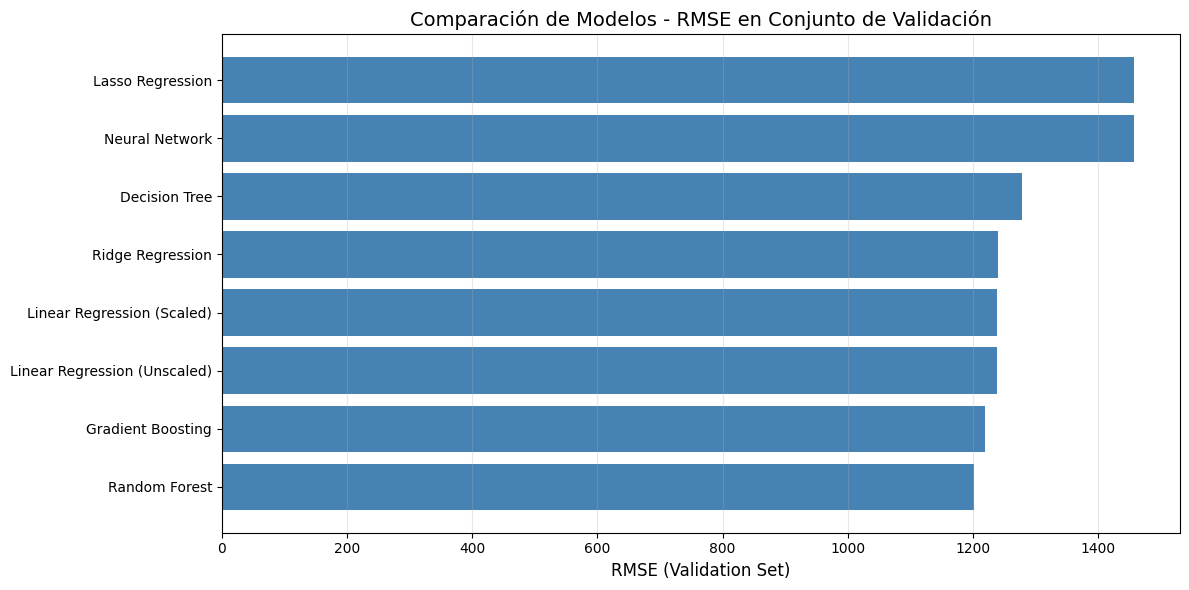

In [25]:
# Gráfico de comparación de RMSE en Validation
val_results = df_comparison[df_comparison['Set'] == 'Validation'].sort_values('RMSE')

plt.figure(figsize=(12, 6))
plt.barh(val_results['Model'], val_results['RMSE'], color='steelblue')
plt.xlabel('RMSE (Validation Set)', fontsize=12)
plt.title('Comparación de Modelos - RMSE en Conjunto de Validación', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

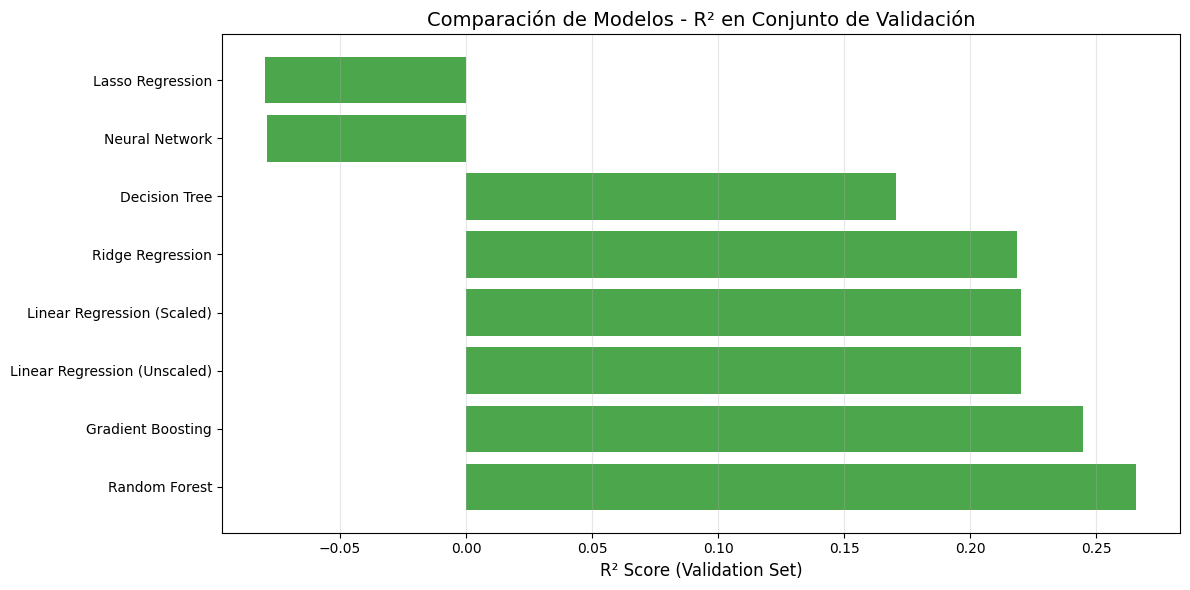

In [26]:
# Gráfico de R² Score
val_r2 = df_comparison[df_comparison['Set'] == 'Validation'].sort_values('R2', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(val_r2['Model'], val_r2['R2'], color='green', alpha=0.7)
plt.xlabel('R² Score (Validation Set)', fontsize=12)
plt.title('Comparación de Modelos - R² en Conjunto de Validación', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_r2.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Predicciones para Kaggle

### 7.1 Selección del Modelo Final

Basándonos en las métricas de validación, seleccionamos el mejor modelo para generar las predicciones finales.

In [27]:
# Identificar el mejor modelo según RMSE en validation
best_model_row = df_comparison[df_comparison['Set'] == 'Validation'].sort_values('RMSE').iloc[0]
print(f"Mejor modelo según RMSE en Validation:")
print(f"  Modelo: {best_model_row['Model']}")
print(f"  RMSE:   ${best_model_row['RMSE']:,.2f}")
print(f"  MAE:    ${best_model_row['MAE']:,.2f}")
print(f"  R²:     {best_model_row['R2']:.6f}")

Mejor modelo según RMSE en Validation:
  Modelo: Random Forest
  RMSE:   $1,201.98
  MAE:    $830.09
  R²:     0.265905


### 7.2 Generar Predicciones para Todos los Modelos

In [28]:
# Diccionario de modelos y datos correspondientes
models_for_prediction = {
    'linear_regression_unscaled': (lr_unscaled, df_test_encoded.values),
    'linear_regression_scaled': (lr_scaled, df_test_scaled),
    'ridge': (ridge, df_test_scaled),
    'lasso': (lasso, df_test_scaled),
    'decision_tree': (dt, df_test_encoded.values),
    'random_forest': (rf, df_test_encoded.values),
    'gradient_boosting': (gb, df_test_encoded.values),
    'neural_network': (nn, df_test_scaled)
}

print("Generando predicciones para todos los modelos...\n")

for model_name, (model, X_test_data) in models_for_prediction.items():
    # Hacer predicciones
    y_pred = model.predict(X_test_data)
    
    # Convertir de escala logarítmica a original
    y_pred_original = np.expm1(y_pred)
    
    # Crear DataFrame con predicciones
    predictions_df = pd.DataFrame({
        'id': test_ids,
        'price': y_pred_original
    })
    
    # Guardar predicciones
    output_file = f'../predictions/predictions_{model_name}.csv'
    predictions_df.to_csv(output_file, index=False)
    
    print(f"✓ {model_name}: {output_file}")
    print(f"  Precio medio predicho: ${y_pred_original.mean():,.2f}")
    print(f"  Precio mínimo:         ${y_pred_original.min():,.2f}")
    print(f"  Precio máximo:         ${y_pred_original.max():,.2f}")
    print()

print("\n✓ Todas las predicciones guardadas en la carpeta 'predictions/'")

Generando predicciones para todos los modelos...

✓ linear_regression_unscaled: ../predictions/predictions_linear_regression_unscaled.csv
  Precio medio predicho: $2,006.95
  Precio mínimo:         $312.94
  Precio máximo:         $10,107.14



C:\Users\larro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


✓ linear_regression_scaled: ../predictions/predictions_linear_regression_scaled.csv
  Precio medio predicho: $2,006.95
  Precio mínimo:         $312.94
  Precio máximo:         $10,107.14

✓ ridge: ../predictions/predictions_ridge.csv
  Precio medio predicho: $2,005.13
  Precio mínimo:         $304.97
  Precio máximo:         $10,154.46

✓ lasso: ../predictions/predictions_lasso.csv
  Precio medio predicho: $1,846.07
  Precio mínimo:         $1,846.07
  Precio máximo:         $1,846.07

✓ decision_tree: ../predictions/predictions_decision_tree.csv
  Precio medio predicho: $2,040.92
  Precio mínimo:         $179.00
  Precio máximo:         $7,175.00



C:\Users\larro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\larro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


✓ random_forest: ../predictions/predictions_random_forest.csv
  Precio medio predicho: $2,022.34
  Precio mínimo:         $411.06
  Precio máximo:         $6,475.01

✓ gradient_boosting: ../predictions/predictions_gradient_boosting.csv
  Precio medio predicho: $1,994.72
  Precio mínimo:         $472.18
  Precio máximo:         $4,704.05

✓ neural_network: ../predictions/predictions_neural_network.csv
  Precio medio predicho: $2,119.99
  Precio mínimo:         $393.97
  Precio máximo:         $70,164.20


✓ Todas las predicciones guardadas en la carpeta 'predictions/'


C:\Users\larro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


## 8. Conclusiones

### Resumen del Proceso:

1. **Preprocesamiento:**
   - Eliminación del top 5% de outliers en price
   - Imputación de valores nulos en reviews_per_month y last_review
   - Transformación logarítmica (log1p) para reducir asimetría

2. **Feature Engineering:**
   - Creación de 7 nuevas features: distance_to_center, features temporales, categorías de noches, host indicators, reviews ratio
   - One-hot encoding de room_type y neighbourhood
   - Total de features: ~66

3. **Modelos Entrenados:**
   - 8 modelos diferentes: Linear Regression (x2), Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting, Neural Network
   - Evaluación con métricas: MAE, RMSE, R²

4. **Gestión de Data Leakage:**
   - Split realizado antes del scaling
   - StandardScaler entrenado solo en train set
   - No se eliminaron outliers en test set

### Próximos Pasos:
- Subir las predicciones del mejor modelo a Kaggle
- Experimentar con hiperparámetros usando GridSearchCV
- Realizar ablation study para feature importance